<h2>Funwave-TVD</h2>
Funwave-TVD is a code to simulate the shallow water and Boussinesq equations written by Dr. Fengyan Shi. It is capable of running a variety of complex ocean simulations. For more information, see Dr. Fengyan Shi's website: https://fengyanshi.github.io/shi_website/_build/html/funwave.html

We will use it as our example scientific code for this tutorial because it is reasonably complex, real scientific code but can be compiled and run quickly.

In [1]:
!mkdir -p ~/agave

%cd ~/agave

!pip3 install --upgrade setvar

import re
import os
import sys
from setvar import *
from time import sleep

# This cell enables inline plotting in the notebook
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

/home/jovyan/agave
Requirement already up-to-date: setvar in /opt/conda/lib/python3.6/site-packages


The parameter file for Funwave-TVD is called "input.txt". Here we create it using writefile. You don't need to understand the details of how this file for this tutorial.

In [2]:
writefile("input.txt","""
!INPUT FILE FOR FUNWAVE_TVD
  ! NOTE: all input parameter are capital sensitive
  ! --------------------TITLE-------------------------------------
  ! title only for log file
TITLE = VESSEL
  ! -------------------HOT START---------------------------------
HOT_START = F
FileNumber_HOTSTART = 1
  ! -------------------PARALLEL INFO-----------------------------
  ! 
  !    PX,PY - processor numbers in X and Y
  !    NOTE: make sure consistency with mpirun -np n (px*py)
  !    
PX = 2
PY = 1
  ! --------------------DEPTH-------------------------------------
  ! Depth types, DEPTH_TYPE=DATA: from depth file
  !              DEPTH_TYPE=FLAT: idealized flat, need depth_flat
  !              DEPTH_TYPE=SLOPE: idealized slope, 
  !                                 need slope,SLP starting point, Xslp
  !                                 and depth_flat
DEPTH_TYPE = FLAT
DEPTH_FLAT = 10.0
  ! -------------------PRINT---------------------------------
  ! PRINT*,
  ! result folder
RESULT_FOLDER = output/

  ! ------------------DIMENSION-----------------------------
  ! global grid dimension
Mglob = 500
Nglob = 100

  ! ----------------- TIME----------------------------------
  ! time: total computational time/ plot time / screen interval 
  ! all in seconds
TOTAL_TIME = 3.0
PLOT_INTV = 1.0
PLOT_INTV_STATION = 50000.0
SCREEN_INTV = 1.0
HOTSTART_INTV = 360000000000.0

WAVEMAKER = INI_GAU
AMP = 3.0
Xc = 250.0
Yc = 50.0
WID = 20.0

  ! -----------------GRID----------------------------------
  ! if use spherical grid, in decimal degrees
  ! cartesian grid sizes
DX = 1.0
DY = 1.0
  ! ----------------SHIP WAKES ----------------------------
VESSEL_FOLDER = ./
NumVessel = 2
  ! -----------------OUTPUT-----------------------------
ETA = T
U = T
V = T
""")

Writing file `input.txt'


Here is a simple bash script to run the code....

In [3]:
writefile("run.sh","""
#!/bin/bash
export LD_LIBRARY_PATH=/usr/local/lib
mkdir -p rundir
cd ./rundir
cp ../input.txt .
mpirun -np 2 ~/FUNWAVE-TVD/src/funwave_vessel
""")

Writing file `run.sh'


## FOLLOWING ALONG AT HOME  

If you are following along at home using the docker-compose stack, you will need to run the following cell to get the hsotname and port of your tcp tunnel so Agave can contact your system without a public IP address.

In [4]:
if os.environ.get('USE_TUNNEL') == 'True': 
    # fetch the hostname and port of the reverse tunnel running in the sandbox 
    # so Agave can connect to our local sandbox
    !echo $(ssh -q -o StrictHostKeyChecking=no -o UserKnownHostsFile=/dev/null sandbox 'curl -s  http://localhost:4040/api/tunnels | jq -r '.tunnels[0].public_url'') > ngrok_url.txt  
    !cat ngrok_url.txt | sed 's|^tcp://||'
    !cat ngrok_url.txt | sed 's|^tcp://||' | sed -r 's#(.*):(.*)#\1#' > ngrok_host.txt
    !cat ngrok_url.txt | sed 's|^tcp://||' | sed -r 's#(.*):(.*)#\2#' > ngrok_port.txt

    # set the environment variables otherwise set when running in a training cluster
    os.environ['VM_PORT'] = readfile('ngrok_port.txt').strip()
    os.environ['VM_MACHINE'] = readfile('ngrok_host.txt').strip()
    os.environ['AGAVE_SYSTEM_HOST'] = readfile('ngrok_host.txt').strip()
    os.environ['AGAVE_SYSTEM_PORT'] = readfile('ngrok_port.txt').strip()
    !echo "VM_PORT=$VM_PORT"
    !echo "VM_MACHINE=$VM_MACHINE"
    setvar("VM_IPADDRESS=$(getent hosts ${VM_MACHINE}|cut -d' ' -f1)")

0.tcp.ngrok.io:10322
Reading file `ngrok_port.txt'
Reading file `ngrok_host.txt'
Reading file `ngrok_host.txt'
Reading file `ngrok_port.txt'
VM_PORT=10322
VM_MACHINE=0.tcp.ngrok.io
VM_IPADDRESS=52.15.194.28


Here's how the average developer might run the code when doing their research.

In [5]:
!scp -o "StrictHostKeyChecking=no" -P $VM_PORT input.txt run.sh $VM_IPADDRESS:.
!ssh -p $VM_PORT $VM_IPADDRESS bash run.sh

input.txt                                     100% 1753     1.7KB/s   00:00    
run.sh                                        100%  141     0.1KB/s   00:00    
 BATHY_CORRECTION DOES NOT EXIST. USE DEFAULT VALUE
 INI_UVZ DOES NOT EXIST. USE DEFAULT VALUE
 WaterLevel DOES NOT EXIST. USE DEFAULT VALUE
 ETA_LIMITER DOES NOT EXIST. USE DEFAULT VALUE
 EqualEnergy DOES NOT EXIST. USE DEFAULT VALUE
 PERIODIC DOES NOT EXIST. USE DEFAULT VALUE
 DIFFUSION_SPONGE DOES NOT EXIST. USE DEFAULT VALUE
 DIRECT_SPONGE DOES NOT EXIST. USE DEFAULT VALUE
 FRICTION_SPONGE DOES NOT EXIST. USE DEFAULT VALUE
 OBSTACLE_FILE DOES NOT EXIST. USE DEFAULT VALUE
 BREAKWATER_FILE DOES NOT EXIST. USE DEFAULT VALUE
 DISPERSION DOES NOT EXIST. USE DEFAULT VALUE
         DISPERSION Default:  DISPERSION
 Gamma1 DOES NOT EXIST. USE DEFAULT VALUE
        Gamma1 Default:  1.0: DISPERSION
 Gamma2 DOES NOT EXIST. USE DEFAULT VALUE
              Gamma2 Default:  1.0: Full nonlinear
 Beta_ref DOES NOT EXIST. USE DEFAULT VALUE
  

Here's how they might retrieve the data.

In [6]:
!ssh -p $VM_PORT $VM_IPADDRESS tar -C rundir -czf output.tgz output
!rm -fr output.tgz output
!scp -q -r -P $VM_PORT $VM_IPADDRESS:output.tgz .
!tar xzf output.tgz

In [7]:
!ls output

eta_00001  eta_00003  eta_00005  u_00002  u_00004  v_00001  v_00003  v_00005
eta_00002  eta_00004  u_00001	 u_00003  u_00005  v_00002  v_00004


Now let's use Python to graph the output

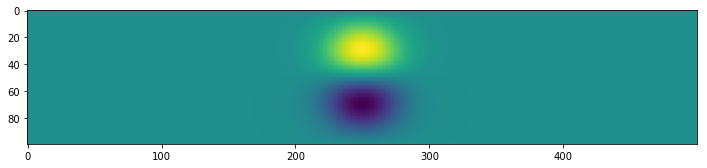

In [8]:
data = np.genfromtxt("output/v_00003")
fig = plt.figure(figsize=(12,12))
pltres = plt.imshow(data[::-1,:])
plt.show()